In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import folium

In [2]:
data = pd.read_csv("database.csv")
data.columns

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Depth Error',
       'Depth Seismic Stations', 'Magnitude', 'Magnitude Type',
       'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap',
       'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID',
       'Source', 'Location Source', 'Magnitude Source', 'Status'],
      dtype='object')

In [3]:
data = data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8


In [4]:
import datetime

timestamp = []

# Loop over 'Date' and 'Time' columns to convert them to Unix timestamps
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d + ' ' + t, '%m/%d/%Y %H:%M:%S')
        
        if ts.year < 1900 or ts.year > 2100:
            timestamp.append('Invalid Date')  
        else:
            timestamp.append(ts.timestamp())
    
    except ValueError:
        timestamp.append('Invalid Date')
    except OSError as e:
        print(f"Error with date {d} {t}: {e}")
        timestamp.append('Invalid Date')

data['Timestamp'] = pd.Series(timestamp)


final_data = data.drop(columns=['Date', 'Time'])

final_data = final_data[final_data['Timestamp'] != 'Invalid Date']

print(final_data.head())


Error with date 01/02/1965 13:44:18: [Errno 22] Invalid argument
Error with date 01/04/1965 11:29:49: [Errno 22] Invalid argument
Error with date 01/05/1965 18:05:58: [Errno 22] Invalid argument
Error with date 01/08/1965 18:49:43: [Errno 22] Invalid argument
Error with date 01/09/1965 13:32:50: [Errno 22] Invalid argument
Error with date 01/10/1965 13:36:32: [Errno 22] Invalid argument
Error with date 01/12/1965 13:32:25: [Errno 22] Invalid argument
Error with date 01/15/1965 23:17:42: [Errno 22] Invalid argument
Error with date 01/16/1965 11:32:37: [Errno 22] Invalid argument
Error with date 01/17/1965 10:43:17: [Errno 22] Invalid argument
Error with date 01/17/1965 20:57:41: [Errno 22] Invalid argument
Error with date 01/24/1965 00:11:17: [Errno 22] Invalid argument
Error with date 01/29/1965 09:35:30: [Errno 22] Invalid argument
Error with date 02/01/1965 05:27:06: [Errno 22] Invalid argument
Error with date 02/02/1965 15:56:51: [Errno 22] Invalid argument
Error with date 02/04/196

In [5]:
data['Timestamp'] = pd.to_datetime(
    data['Date'] + ' ' + data['Time'], 
    format='%m/%d/%Y %H:%M:%S', 
    errors='coerce'
)

data['Timestamp'] = data['Timestamp'].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

final_data = data.drop(columns=['Date', 'Time'])

final_data = final_data.dropna(subset=['Timestamp'])

print(final_data.head())

   Latitude  Longitude  Depth  Magnitude    Timestamp
0    19.246    145.616  131.6        6.0 -157630542.0
1     1.863    127.352   80.0        5.8 -157465811.0
2   -20.579   -173.972   20.0        6.2 -157355642.0
3   -59.076    -23.557   15.0        5.8 -157093817.0
4    11.938    126.427   15.0        5.8 -157026430.0


In [6]:
from folium.plugins import HeatMap

m = folium.Map(location=[0, 0], zoom_start=2, 
               tiles="Stamen Terrain", 
               attr="Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.")


heat_data = [[row['Latitude'], row['Longitude']] for index, row in data.iterrows()]

HeatMap(heat_data).add_to(m)

# Display the map
m.save("earthquake_heatmap_one.html")


In [7]:
from folium.plugins import HeatMap

m = folium.Map(location=[0, 0], zoom_start=2, 
               tiles="CartoDB positron",
               attr="Map tiles by CartoDB, under ODbL. Data by OpenStreetMap, under ODbL.")

heat_data = [[row['Latitude'], row['Longitude'], row['Magnitude']] for index, row in data.iterrows()]

HeatMap(heat_data, 
        radius=15,            
        blur=10,              
        max_zoom=13,          
        min_opacity=0.2,      
        max_val=10,           
        gradient={           
            0.4: 'blue',
            0.6: 'lime',
            0.8: 'yellow',
            1.0: 'red'
        }).add_to(m)

title_html = '''
   <div style="font-size: 20px; font-weight: bold; text-align: center; color: #1F618D; background-color: rgba(255, 255, 255, 0.8); padding: 10px; border-radius: 5px;">
       <h3>Global Earthquake Frequency Heatmap</h3>
       <p>Visualizes the frequency of earthquakes worldwide. Red represents areas with high frequency, and blue indicates lower frequency.</p>
   </div>
'''

popup = folium.Popup(title_html, max_width=500)
folium.Marker([0, 0], popup=popup, icon=None).add_to(m)

legend_html = '''
   <div style="position: fixed; 
               bottom: 50px; left: 50px; width: 220px; height: 160px; 
               background-color: rgba(255, 255, 255, 0.7); 
               border:2px solid grey; z-index:9999; font-size:14px; padding:10px;">
       <b style="font-size: 16px; color: #1F618D;">Earthquake Frequency Legend</b><br>
       <i style="background:blue; width: 15px; height: 15px; display: inline-block;"></i> Low Frequency<br>
       <i style="background:lime; width: 15px; height: 15px; display: inline-block;"></i> Medium Frequency<br>
       <i style="background:yellow; width: 15px; height: 15px; display: inline-block;"></i> High Frequency<br>
       <i style="background:red; width: 15px; height: 15px; display: inline-block;"></i> Very High Frequency
   </div>
'''

m.get_root().html.add_child(folium.Element(legend_html))


for _, row in data.sample(10).iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"<b>Magnitude:</b> {row['Magnitude']}<br><b>Depth:</b> {row['Depth']} km",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

m.save("earthquake_heatmap_two_enhanced_with_design.html")


C:\Users\DELL\AppData\Local\Temp\ipykernel_26864\2748008399.py:9: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(heat_data,


In [8]:
from folium.plugins import HeatMap, MarkerCluster

m = folium.Map(location=[0, 0], zoom_start=2, 
               tiles="CartoDB positron", 
               attr="Map tiles by CartoDB, under ODbL. Data by OpenStreetMap, under ODbL.")

heat_data = [[row['Latitude'], row['Longitude'], row['Magnitude']] for index, row in data.iterrows()]

HeatMap(heat_data, 
        radius=15,            
        blur=10,              
        max_zoom=13,          
        min_opacity=0.2,      
        max_val=10,           
        gradient={        
            0.4: 'blue',
            0.6: 'lime',
            0.8: 'yellow',
            1.0: 'red'
        }).add_to(m)

title_html = '''
   <div style="font-size: 20px; font-weight: bold; text-align: center; color: #1F618D; background-color: rgba(255, 255, 255, 0.8); padding: 10px; border-radius: 5px;">
       <h3>Global Earthquake Frequency Heatmap</h3>
       <p>Visualizes the frequency of earthquakes worldwide. Red represents areas with high frequency, and blue indicates lower frequency.</p>
   </div>
'''

popup = folium.Popup(title_html, max_width=500)
folium.Marker([0, 0], popup=popup, icon=None).add_to(m)


legend_html = '''
   <div style="position: fixed; 
               bottom: 50px; left: 50px; width: 220px; height: 160px; 
               background-color: rgba(255, 255, 255, 0.7); 
               border:2px solid grey; z-index:9999; font-size:14px; padding:10px;">
       <b style="font-size: 16px; color: #1F618D;">Earthquake Frequency Legend</b><br>
       <i style="background:blue; width: 15px; height: 15px; display: inline-block;"></i> Low Frequency<br>
       <i style="background:lime; width: 15px; height: 15px; display: inline-block;"></i> Medium Frequency<br>
       <i style="background:yellow; width: 15px; height: 15px; display: inline-block;"></i> High Frequency<br>
       <i style="background:red; width: 15px; height: 15px; display: inline-block;"></i> Very High Frequency
   </div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

marker_cluster = MarkerCluster().add_to(m)


for _, row in data.sample(2000).iterrows(): 
    color = 'green' if row['Magnitude'] < 5 else 'orange' if row['Magnitude'] < 6 else 'red'  
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"<b>Location:</b> {row['Latitude']}, {row['Longitude']}<br>"
              f"<b>Magnitude:</b> {row['Magnitude']}<br>"
              f"<b>Depth:</b> {row['Depth']} km<br>"
              f"<b>Date:</b> {pd.to_datetime(row['Timestamp'], unit='s').strftime('%Y-%m-%d %H:%M:%S')}",
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(marker_cluster)

ring_of_fire_coords = [
    [60, -150], [55, -120], [40, -105], [35, -80], [15, -60], [10, -40],
    [0, -30], [-10, -20], [-25, 140], [-30, 150], [-40, 155], [-60, 170],
    [-60, 140], [-50, 120], [-40, 115], [-35, 125], [-25, 135], [-10, 155],
    [0, 160], [10, 170], [20, 175], [40, 180], [60, -150]
]

folium.Polygon(
    locations=ring_of_fire_coords, 
    color='orange', 
    weight=2.5, 
    fill=True, 
    fill_opacity=0.2,
    popup='Ring of Fire - Tectonic Plate Boundary'
).add_to(m)

m.save("earthquake_heatmap_three_enhanced_with_design.html")

C:\Users\DELL\AppData\Local\Temp\ipykernel_26864\2554612529.py:9: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(heat_data,


In [9]:
features = final_data[['Latitude', 'Longitude', 'Depth', 'Timestamp']]
target = final_data['Magnitude']  # or you could select another target like Depth


scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

print(f"Training data size: {X_train.shape}")
print(f"Test data size: {X_test.shape}")


Training data size: (18727, 4)
Test data size: (4682, 4)


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.1851805256141647
R-squared: 0.004035344373026439


In [11]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

class EarthquakeNN(nn.Module):
    def __init__(self):
        super(EarthquakeNN, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = EarthquakeNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

with torch.no_grad():
    model.eval()
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()

from sklearn.metrics import mean_squared_error, r2_score
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))


Epoch [10/100], Loss: 28.640504837036133
Epoch [20/100], Loss: 23.919471740722656
Epoch [30/100], Loss: 18.5528564453125
Epoch [40/100], Loss: 13.083569526672363
Epoch [50/100], Loss: 8.158345222473145
Epoch [60/100], Loss: 4.476795673370361
Epoch [70/100], Loss: 2.426649332046509
Epoch [80/100], Loss: 1.6524509191513062
Epoch [90/100], Loss: 1.3838492631912231
Epoch [100/100], Loss: 1.2081592082977295
MSE: 1.193867153417899
R2: -5.4210288008128495


In [12]:
from geopy.distance import geodesic

ring_of_fire_coords = [35.6895, 139.6917] 

def calculate_distance(lat, lon):
    return geodesic((lat, lon), (ring_of_fire_coords)).km

data['Distance_to_Ring_of_Fire'] = data.apply(lambda row: calculate_distance(row['Latitude'], row['Longitude']), axis=1)

print(data.head())


         Date      Time  Latitude  Longitude  Depth  Magnitude    Timestamp  \
0  01/02/1965  13:44:18    19.246    145.616  131.6        6.0 -157630542.0   
1  01/04/1965  11:29:49     1.863    127.352   80.0        5.8 -157465811.0   
2  01/05/1965  18:05:58   -20.579   -173.972   20.0        6.2 -157355642.0   
3  01/08/1965  18:49:43   -59.076    -23.557   15.0        5.8 -157093817.0   
4  01/09/1965  13:32:50    11.938    126.427   15.0        5.8 -157026430.0   

   Distance_to_Ring_of_Fire  
0               1912.832118  
1               3956.098751  
2               7914.124363  
3              17133.878899  
4               2950.476901  


In [13]:
features = data[['Latitude', 'Longitude', 'Depth', 'Timestamp', 'Distance_to_Ring_of_Fire']]
target = data['Magnitude']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

print(f"Training data size: {X_train.shape}")
print(f"Test data size: {X_test.shape}")


Training data size: (18729, 5)
Test data size: (4683, 5)


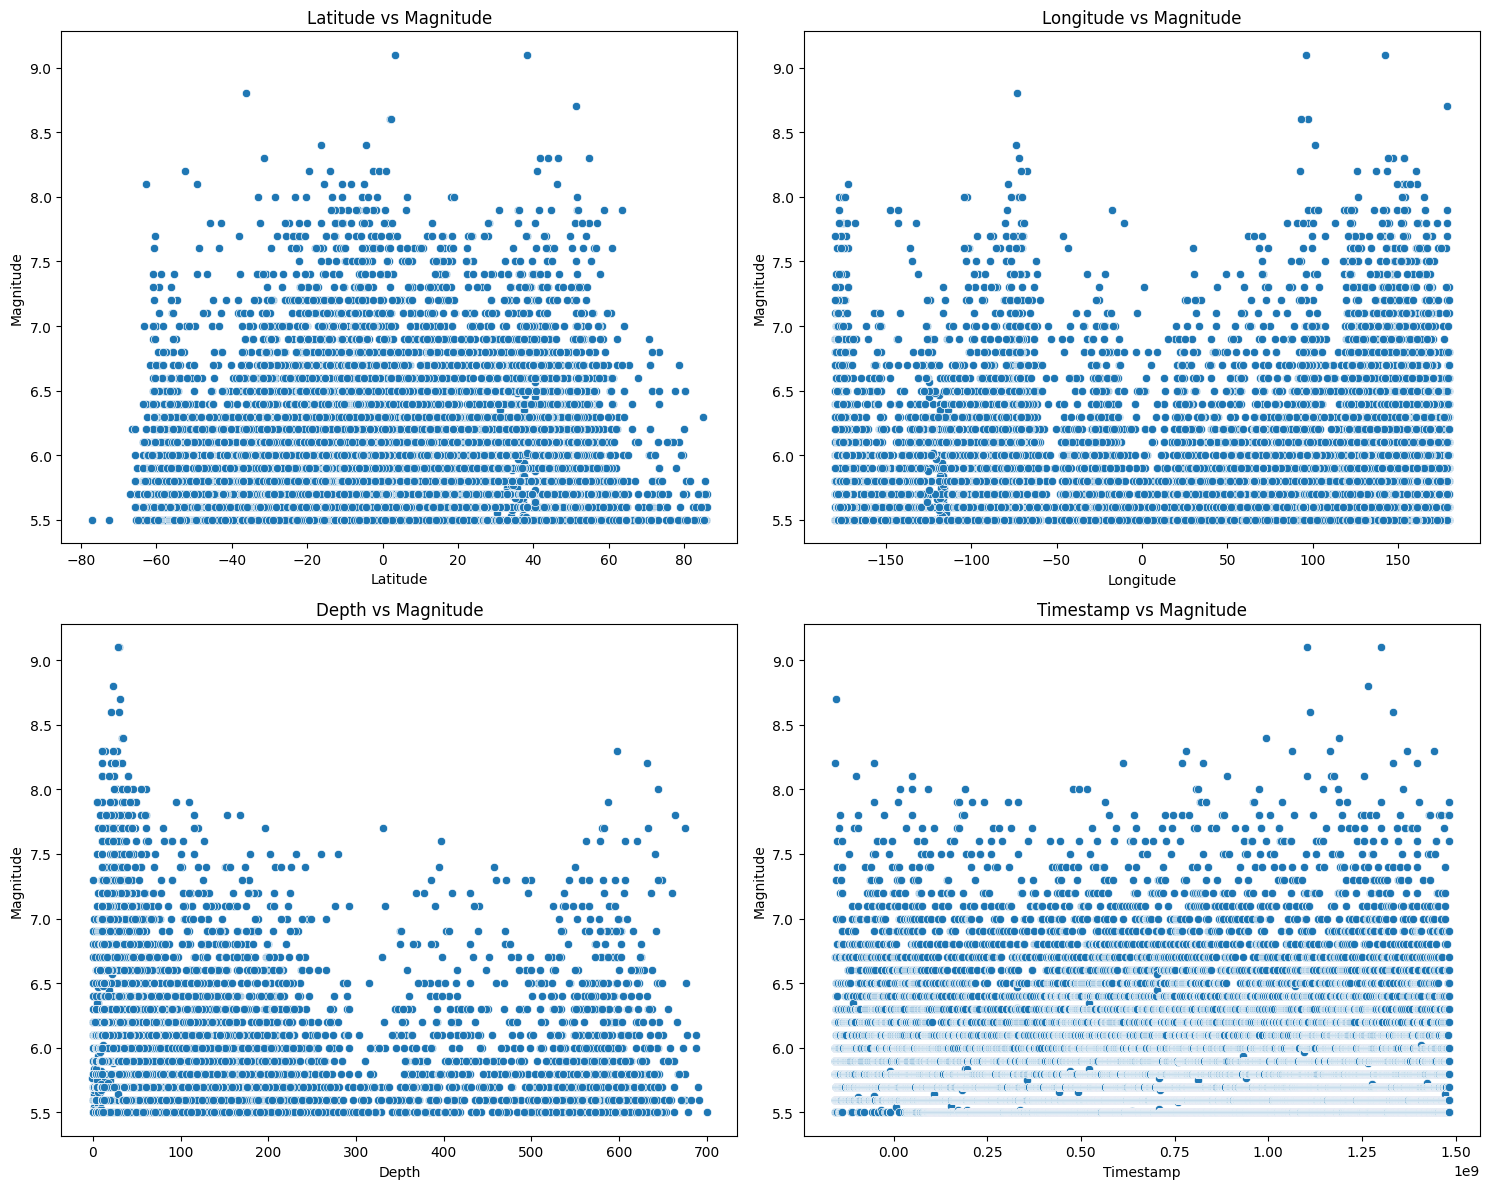

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['Latitude', 'Longitude', 'Depth', 'Timestamp']

plt.figure(figsize=(15, 12))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=final_data[feature], y=final_data['Magnitude'])
    plt.title(f'{feature} vs Magnitude')

plt.tight_layout()
plt.show()


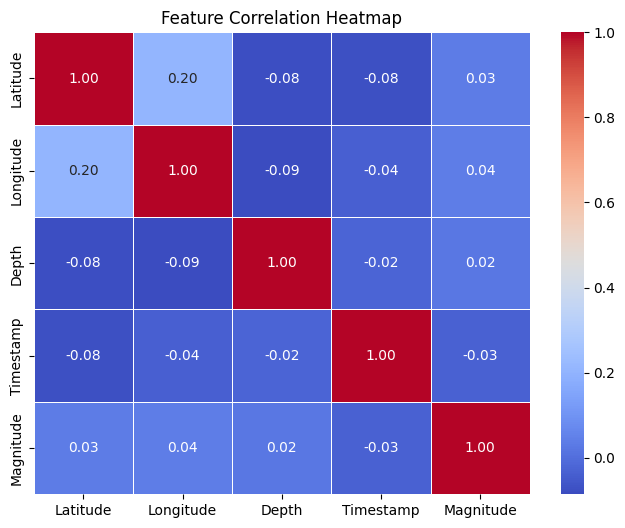

In [15]:
corr_matrix = final_data[['Latitude', 'Longitude', 'Depth', 'Timestamp', 'Magnitude']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()


Mean Squared Error: 0.18518052561416962
R-squared: 0.004035344372999905


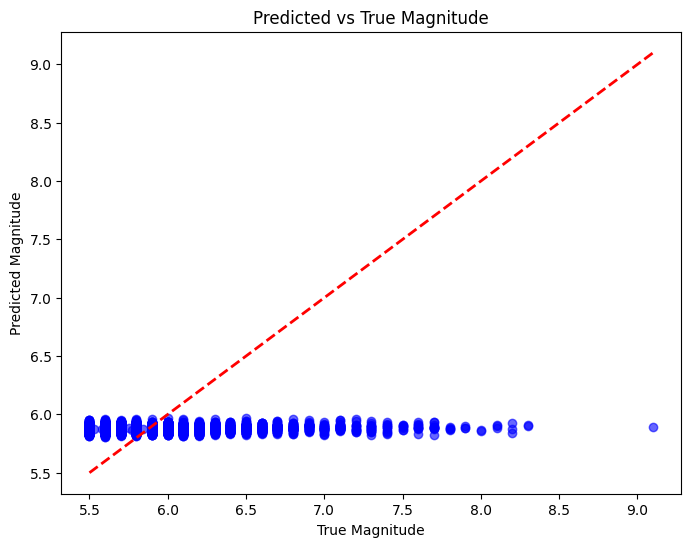

In [16]:
X = final_data[['Latitude', 'Longitude', 'Depth', 'Timestamp']]
y = final_data['Magnitude']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('Predicted vs True Magnitude')
plt.xlabel('True Magnitude')
plt.ylabel('Predicted Magnitude')
plt.show()


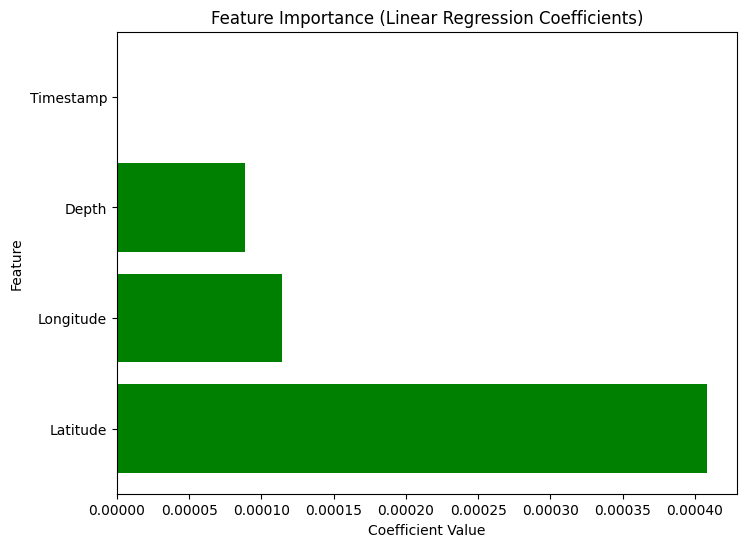

In [17]:
feature_names = ['Latitude', 'Longitude', 'Depth', 'Timestamp']
coefficients = model.coef_

plt.figure(figsize=(8, 6))
plt.barh(feature_names, coefficients, color='green')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()
